In [251]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt
from scipy.stats import poisson
import numpy as np
import scipy.stats as stats
import re

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# weather
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import meteostat
from meteostat import Point, Daily, Stations, Hourly


In [2]:
os.chdir('..')
os.getcwd()

'/Users/benmurphy/Projects/rugby/rugby'

In [3]:
raw_df = pd.read_csv("0_data/match_data/urc_matches.csv")
raw_df

,match_date_dt,match_date_time_dt,season,home_team,away_team,home_score,away_score,home_n_tries,home_n_conversions,home_n_pen_kicks,...,away_n_pen_kicks,away_n_pen_tries,home_forwards_average_age,home_backs_average_age,home_tallest_player,home_pack_weight_kg,away_forwards_average_age,away_backs_average_age,away_tallest_player,away_pack_weight_kg
0,2021-09-24,2021-09-24 18:35:00,21/22,ZEBRE,LIONS,26,38,4.0,2.0,0.0,...,1.0,0.0,26,26,198,924,27,25,199,919
1,2021-09-24,2021-09-24 20:35:00,21/22,CARDIFF,CONNACHT,33,21,5.0,4.0,0.0,...,3.0,0.0,28,27,203,929,26,26,198,892
2,2021-09-24,2021-09-24 20:35:00,21/22,ULSTER,GLASGOW,35,29,5.0,4.0,0.0,...,1.0,1.0,29,26,201,906,28,26,205,912
3,2021-09-25,2021-09-25 14:00:00,21/22,BENETTON,STORMERS,22,18,3.0,2.0,1.0,...,2.0,0.0,24,26,200,909,27,25,200,903
4,2021-09-25,2021-09-25 18:15:00,21/22,LEINSTER,BULLS,31,3,4.0,4.0,1.0,...,1.0,0.0,26,27,201,920,27,26,203,934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,2025-05-17,2025-05-17 15:00:00,24/25,BULLS,DRAGONS,0,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
593,2025-05-17,2025-05-17 17:15:00,24/25,LIONS,OSPREYS,0,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
594,2025-05-17,2025-05-17 18:00:00,24/25,ZEBRE,CONNACHT,0,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0
595,2025-05-17,2025-05-17 19:30:00,24/25,SHARKS,SCARLETS,0,0,NaN,NaN,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [4]:
raw_df = raw_df.loc[raw_df['match_date_dt'] < "2024-12-04"]

raw_df.loc[raw_df['match_date_dt'] == "2024-11-30", "home_score"] = np.nan
raw_df.loc[raw_df['match_date_dt'] == "2024-11-30", "away_score"] = np.nan

raw_df.tail(8)

,match_date_dt,match_date_time_dt,season,home_team,away_team,home_score,away_score,home_n_tries,home_n_conversions,home_n_pen_kicks,...,away_n_pen_kicks,away_n_pen_tries,home_forwards_average_age,home_backs_average_age,home_tallest_player,home_pack_weight_kg,away_forwards_average_age,away_backs_average_age,away_tallest_player,away_pack_weight_kg
499,2024-11-29,2024-11-29 20:35:00,24/25,GLASGOW,SCARLETS,17.0,15.0,2.0,2.0,1.0,...,1.0,0.0,26,27,207,915,29,25,201,909
500,2024-11-29,2024-11-29 20:35:00,24/25,ULSTER,LEINSTER,20.0,27.0,2.0,2.0,2.0,...,1.0,0.0,26,26,199,899,27,25,200,900
501,2024-11-30,2024-11-30 16:00:00,24/25,SHARKS,STORMERS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29,26,203,909,30,27,203,924
502,2024-11-30,2024-11-30 18:15:00,24/25,CARDIFF,DRAGONS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,28,27,201,911,27,26,198,907
503,2024-11-30,2024-11-30 18:30:00,24/25,CONNACHT,BULLS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,29,26,201,901,27,27,201,943
504,2024-11-30,2024-11-30 20:35:00,24/25,EDINBURGH,BENETTON,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,28,26,200,931,28,27,201,916
505,2024-11-30,2024-11-30 20:35:00,24/25,ZEBRE,OSPREYS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,25,26,202,890,27,25,204,868
506,2024-11-30,2024-11-30 20:35:00,24/25,MUNSTER,LIONS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,27,27,201,887,26,26,200,924


In [5]:
raw_df.columns

Index(['match_date_dt', 'match_date_time_dt', 'season', 'home_team',
       'away_team', 'home_score', 'away_score', 'home_n_tries',
       'home_n_conversions', 'home_n_pen_kicks', 'home_n_pen_tries',
       'away_n_tries', 'away_n_conversions', 'away_n_pen_kicks',
       'away_n_pen_tries', 'home_forwards_average_age',
       'home_backs_average_age', 'home_tallest_player', 'home_pack_weight_kg',
       'away_forwards_average_age', 'away_backs_average_age',
       'away_tallest_player', 'away_pack_weight_kg'],
      dtype='object')

In [6]:
def match_outcome(h,a):
    if h > a:
        return 1
    elif h < a:
        return -1
    else:
        return 0
        
raw_df['outcome'] = raw_df.apply(lambda x: match_outcome(x.home_score, x.away_score), axis=1)


raw_df[['match_date_dt', 'home_team', 'away_team', 
    'home_score', 'away_score', 'outcome']]

/var/folders/xr/_sn2jn9s3xd13fp9ljzys7tm0000gn/T/ipykernel_1000/375106086.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['outcome'] = raw_df.apply(lambda x: match_outcome(x.home_score, x.away_score), axis=1)


,match_date_dt,home_team,away_team,home_score,away_score,outcome
0,2021-09-24,ZEBRE,LIONS,26.0,38.0,-1
1,2021-09-24,CARDIFF,CONNACHT,33.0,21.0,1
2,2021-09-24,ULSTER,GLASGOW,35.0,29.0,1
3,2021-09-25,BENETTON,STORMERS,22.0,18.0,1
4,2021-09-25,LEINSTER,BULLS,31.0,3.0,1
...,...,...,...,...,...,...
502,2024-11-30,CARDIFF,DRAGONS,NaN,NaN,0
503,2024-11-30,CONNACHT,BULLS,NaN,NaN,0
504,2024-11-30,EDINBURGH,BENETTON,NaN,NaN,0
505,2024-11-30,ZEBRE,OSPREYS,NaN,NaN,0


In [7]:
raw_df['outcome'].value_counts()

outcome
 1    322
-1    169
 0     16
Name: count, dtype: int64

In [303]:
features = ['match_date_dt', 'home_team', 'away_team', 'season',
            'home_score', 'away_score', 'outcome',
            
            'home_n_tries', 'away_n_tries', 
            'home_n_conversions', 'away_n_conversions',
            'home_n_pen_kicks', 'away_n_pen_kicks',
            'home_n_pen_tries', 'away_n_pen_tries', 

            
            'home_forwards_average_age', 'home_backs_average_age',
            'away_forwards_average_age', 'away_backs_average_age',
            'home_tallest_player', 'home_pack_weight_kg',
            'away_tallest_player', 'away_pack_weight_kg'
           ]

# home data
home_data = raw_df[features].copy()

home_data['team_location'] = "Home"
home_data.rename(columns={"home_team": "team",
                    "away_team": "opponents",
                    "home_score": "team_score",
                    "away_score": "opponent_score",

                    "home_n_tries": "tries_scored",
                    "away_n_tries": "tries_conceded",
                    "home_n_conversions": "conversions_scored",
                    "away_n_conversions": "conversions_conceded",
                    "home_n_pen_kicks": "pen_kicks_scored",
                    "away_n_pen_kicks": "pen_kicks_conceded",
                    "home_n_pen_tries": "pen_tries_scored",
                    "away_n_pen_tries": "pen_tries_conceded",
                    
                    "home_forwards_average_age": "team_forwards_average_age",
                    "home_backs_average_age": "team_backs_average_age",
                    "away_forwards_average_age": "opposition_forwards_average_age",
                    "away_backs_average_age": "opposition_backs_average_age",

                    "home_tallest_player": "team_tallest_player",
                    "away_tallest_player": "opposition_tallest_player",

                    "home_pack_weight_kg": "team_pack_weight_kg",
                    "away_pack_weight_kg": "opposition_pack_weight_kg"
                    },
                    inplace=True)

# away data
away_data = raw_df[features].copy()
away_data['team_location'] = "Away"
away_data.rename(columns={"away_team": "team",
                    "home_team": "opponents",
                    "away_score": "team_score",
                    "home_score": "opponent_score",
                    "away_n_tries": "tries_scored",
                    "home_n_tries": "tries_conceded",
                    "away_n_conversions": "conversions_scored",
                    "home_n_conversions": "conversions_conceded",
                    "away_n_pen_kicks": "pen_kicks_scored",
                    "home_n_pen_kicks": "pen_kicks_conceded",
                    "away_n_pen_tries": "pen_tries_scored",
                    "home_n_pen_tries": "pen_tries_conceded",

                    "away_forwards_average_age": "team_forwards_average_age",
                    "away_backs_average_age": "team_backs_average_age",
                    "home_forwards_average_age": "opposition_forwards_average_age",
                    "home_backs_average_age": "opposition_backs_average_age",

                    "away_tallest_player": "team_tallest_player",
                    "home_tallest_player": "opposition_tallest_player",

                    "away_pack_weight_kg": "team_pack_weight_kg",
                    "home_pack_weight_kg": "opposition_pack_weight_kg"

                    },
                    inplace=True)

# concat dfs together
df = pd.concat([home_data, away_data])

df = df.sort_values(by='match_date_dt').reset_index(drop=False, names='match_per_row_index')

# df['tries_scored'] = df['tries_scored'] - df['pen_tries_scored']

df['conversions_scored'] = df['conversions_scored'] + df['pen_tries_scored']

df

,match_per_row_index,match_date_dt,team,opponents,season,team_score,opponent_score,outcome,tries_scored,tries_conceded,...,pen_tries_conceded,team_forwards_average_age,team_backs_average_age,opposition_forwards_average_age,opposition_backs_average_age,team_tallest_player,team_pack_weight_kg,opposition_tallest_player,opposition_pack_weight_kg,team_location
0,0,2021-09-24,ZEBRE,LIONS,21/22,26.0,38.0,-1,4.0,5.0,...,0.0,26,26,27,25,198,924,199,919,Home
1,1,2021-09-24,CONNACHT,CARDIFF,21/22,21.0,33.0,1,2.0,5.0,...,0.0,26,26,28,27,198,892,203,929,Away
2,0,2021-09-24,LIONS,ZEBRE,21/22,38.0,26.0,-1,5.0,4.0,...,1.0,27,25,26,26,199,919,198,924,Away
3,2,2021-09-24,GLASGOW,ULSTER,21/22,29.0,35.0,1,4.0,5.0,...,1.0,28,26,29,26,205,912,201,906,Away
4,1,2021-09-24,CARDIFF,CONNACHT,21/22,33.0,21.0,1,5.0,2.0,...,0.0,28,27,26,26,203,929,198,892,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,2024-11-30,CONNACHT,BULLS,24/25,NaN,NaN,0,NaN,NaN,...,NaN,29,26,27,27,201,901,201,943,Home
1010,502,2024-11-30,CARDIFF,DRAGONS,24/25,NaN,NaN,0,NaN,NaN,...,NaN,28,27,27,26,201,911,198,907,Home
1011,501,2024-11-30,SHARKS,STORMERS,24/25,NaN,NaN,0,NaN,NaN,...,NaN,29,26,30,27,203,909,203,924,Home
1012,505,2024-11-30,OSPREYS,ZEBRE,24/25,NaN,NaN,0,NaN,NaN,...,NaN,27,25,25,26,204,868,202,890,Away


In [243]:
s=5

temp_span = df.groupby('team')[['tries_scored']].ewm(span=s, min_periods=5).mean().groupby(level=0).shift(periods=1).reset_index() \
                                                .rename(columns={"level_1":"row_index",
                                                                  "tries_scored": f"ewm_tries_scored_last_{s}"})

temp_span.index = temp_span['row_index']

temp_span = temp_span.sort_index()


In [249]:
span_testing_df = pd.concat([temp_span, df[['outcome', 'match_date_dt']]], axis=1)
span_testing_df = span_testing_df.loc[span_testing_df['match_date_dt'] < '2024-11-29']

span_testing_df = span_testing_df.dropna()
span_testing_df

,team,row_index,ewm_tries_scored_last_5,outcome,match_date_dt
76,CONNACHT,76,3.492891,1,2021-11-26
77,OSPREYS,77,1.421801,1,2021-11-26
78,ULSTER,78,3.075829,-1,2021-11-27
79,GLASGOW,79,2.246445,1,2021-11-27
80,BENETTON,80,3.298578,1,2021-11-27
...,...,...,...,...,...
993,CONNACHT,993,3.129071,1,2024-10-26
994,LEINSTER,994,4.609369,1,2024-10-26
995,SHARKS,995,2.767263,1,2024-10-26
996,OSPREYS,996,2.100406,1,2024-10-26


In [254]:
lr = LogisticRegression()

X = span_testing_df[['ewm_tries_scored_last_5']]
y = span_testing_df['outcome']

kfold = StratifiedKFold(n_splits=5)
ave_cv_score = cross_val_score(lr, X, y, scoring='neg_log_loss', cv=kfold).mean()
print(ave_cv_score*-1)

0.7278506171979262


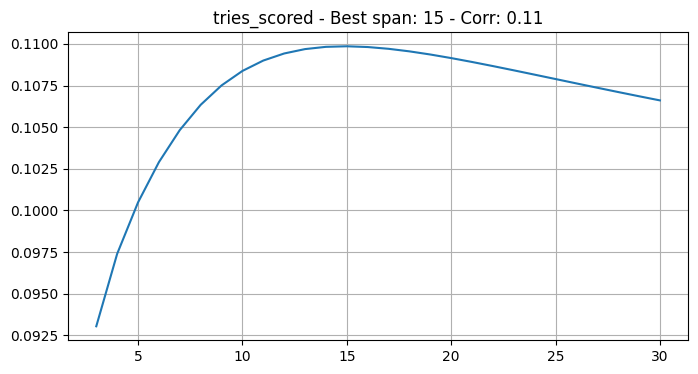

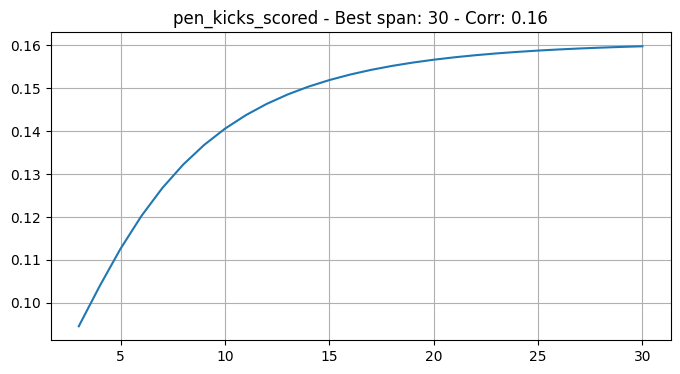

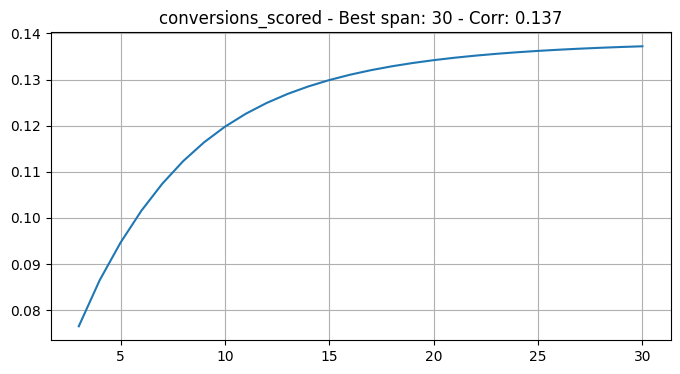

In [380]:

location_df = df.loc[df['team_location']=='Away'].copy()



for feature in ['tries_scored', 'pen_kicks_scored', 'conversions_scored']:
    corrs = []
    spans = []
    highest_corr = 0
    best_span = 3
    
    for s in range(3, 31):
        temp_span = location_df.groupby('team')[[feature]].ewm(span=s, min_periods=8).mean().groupby(level=0).shift(periods=1).reset_index() \
                                                        .rename(columns={"level_1":"row_index",
                                                                          feature: f"ewm_{feature}_last_{s}"})
        temp_span.index = temp_span['row_index']
        temp_span = temp_span.sort_index()
    
        span_testing_df = pd.concat([temp_span, location_df[[feature, 'match_date_dt']]], axis=1)
        span_testing_df = span_testing_df.loc[span_testing_df['match_date_dt'] < '2024-11-29']
        span_testing_df = span_testing_df.dropna()
    
        corr_ = span_testing_df[[f'ewm_{feature}_last_{s}', feature]].corr().iloc[0].iloc[1]
    
        
        # lr = LogisticRegression()
        # X = span_testing_df[[f'ewm_tries_scored_last_{s}']]
        # y = span_testing_df['tries_scored']
        # kfold = StratifiedKFold(n_splits=5)
        # ave_cv_score = cross_val_score(lr, X, y, scoring='neg_log_loss', cv=kfold).mean()
        # print(ave_cv_score*-1)
    
        spans.append(s)
        corrs.append(corr_)

        if corr_ > highest_corr:
            highest_corr = corr_
            best_span = s
        
    plt.figure(figsize=(8,4))
    plt.plot(spans, corrs)
    plt.grid(True)
    plt.title(f"{feature} - Best span: {best_span} - Corr: {round(highest_corr, 3)}")
    plt.show()
    print()

In [ ]:
def get_window_average(df, feature, window_size):

    temp = df.copy()
    feature_name = f"{feature}_last_{window_size}"
    last_n_avg = temp.groupby('team')[[feature]].rolling(window_size, closed='left').mean().reset_index().rename(columns={"level_1":"row_index",
                                                                                                            f"{feature}": feature_name})
    last_n_avg.index = last_n_avg['row_index']
    last_n_avg = last_n_avg.sort_index()

    return last_n_avg[[feature_name]]

In [364]:
def get_feature_ewm(df, feature, span, location=''):

    temp = df.copy()
    feature_name = f"{feature}_ewm_span_{span}_{location}"
    
    last_n_avg = df.groupby('team')[[feature]].ewm(span=span, min_periods=8).mean().groupby(level=0).shift(periods=1).reset_index() \
                                                        .rename(columns={"level_1":"row_index", feature: feature_name})

    last_n_avg.index = last_n_avg['row_index']
    last_n_avg = last_n_avg.sort_index()

    return last_n_avg[[feature_name]]

# Home and Away team ewm for tries, penalties and conversions for all games played

In [365]:
ewm_tries_scored = get_feature_ewm(df, 'tries_scored', 60, location='all_games')
ewm_pen_kicks_scored = get_feature_ewm(df, 'pen_kicks_scored', 29, location='all_games')
ewm_conversions_scored = get_feature_ewm(df, 'conversions_scored', 60, location='all_games')

ewm_tries_conceded = get_feature_ewm(df, 'tries_conceded', 60, location='all_games')
ewm_pen_kicks_conceded = get_feature_ewm(df, 'pen_kicks_conceded', 29, location='all_games')
ewm_conversions_conceded = get_feature_ewm(df, 'conversions_conceded', 60, location='all_games')


ewm_scored = pd.concat([ewm_tries_scored, ewm_pen_kicks_scored, ewm_conversions_scored,
                        ewm_tries_conceded, ewm_pen_kicks_conceded, ewm_conversions_conceded
                                 ], axis=1)

ewm_scored.tail()

,tries_scored_ewm_span_60_all_games,pen_kicks_scored_ewm_span_29_all_games,conversions_scored_ewm_span_60_all_games,tries_conceded_ewm_span_60_all_games,pen_kicks_conceded_ewm_span_29_all_games,conversions_conceded_ewm_span_60_all_games
row_index,,,,,,
1009,3.252595,0.848998,2.280559,3.343801,1.081142,2.482169
1010,2.866456,0.959414,2.052682,3.392695,1.095369,2.512291
1011,3.048239,1.145825,2.313185,3.308128,1.127511,2.454681
1012,2.815928,0.870080,2.067101,3.424646,1.415577,2.347268
1013,3.360582,1.666473,2.586746,3.135876,1.101960,2.191258


In [366]:
# split out home and away
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                 ewm_scored],
                 axis=1).sort_values('match_per_row_index')

home_team_all_games_ewm = temp.loc[temp['team_location']=='Home']
home_team_all_games_ewm.columns = ['home_team_' + i if 'ewm' in i else i for i in home_team_all_games_ewm.columns]
home_team_all_games_ewm.index = home_team_all_games_ewm['match_per_row_index']
home_team_all_games_ewm.sort_index().tail()

,match_per_row_index,team,opponents,team_location,home_team_tries_scored_ewm_span_60_all_games,home_team_pen_kicks_scored_ewm_span_29_all_games,home_team_conversions_scored_ewm_span_60_all_games,home_team_tries_conceded_ewm_span_60_all_games,home_team_pen_kicks_conceded_ewm_span_29_all_games,home_team_conversions_conceded_ewm_span_60_all_games
match_per_row_index,,,,,,,,,,
502,502,CARDIFF,DRAGONS,Home,2.866456,0.959414,2.052682,3.392695,1.095369,2.512291
503,503,CONNACHT,BULLS,Home,3.252595,0.848998,2.280559,3.343801,1.081142,2.482169
504,504,EDINBURGH,BENETTON,Home,3.052285,1.395107,2.290540,3.080121,0.941830,2.214186
505,505,ZEBRE,OSPREYS,Home,2.169635,1.273680,1.378980,5.098506,0.781969,3.724448
506,506,MUNSTER,LIONS,Home,3.528275,0.829373,2.563297,2.574774,1.088889,1.889857


In [367]:
away_team_all_games_ewm = temp.loc[temp['team_location']=='Away']
away_team_all_games_ewm.columns = ['away_team_' + i if 'ewm' in i else i for i in away_team_all_games_ewm.columns]
away_team_all_games_ewm.index = away_team_all_games_ewm['match_per_row_index']
away_team_all_games_ewm.sort_index().tail()

,match_per_row_index,team,opponents,team_location,away_team_tries_scored_ewm_span_60_all_games,away_team_pen_kicks_scored_ewm_span_29_all_games,away_team_conversions_scored_ewm_span_60_all_games,away_team_tries_conceded_ewm_span_60_all_games,away_team_pen_kicks_conceded_ewm_span_29_all_games,away_team_conversions_conceded_ewm_span_60_all_games
match_per_row_index,,,,,,,,,,
502,502,DRAGONS,CARDIFF,Away,2.203611,1.155605,1.759017,4.294576,1.136866,3.155546
503,503,BULLS,CONNACHT,Away,4.126197,1.490815,3.274022,2.712732,1.558626,2.158072
504,504,BENETTON,EDINBURGH,Away,2.916973,1.459489,2.071082,3.478533,0.880966,2.659610
505,505,OSPREYS,ZEBRE,Away,2.815928,0.870080,2.067101,3.424646,1.415577,2.347268
506,506,LIONS,MUNSTER,Away,3.360582,1.666473,2.586746,3.135876,1.101960,2.191258


# Home team ewm for tries, penalties and conversions for only home games played

In [378]:

home_games_only_df = df.loc[df['team_location']=='Home']
ewm_tries_scored_home = get_feature_ewm(home_games_only_df, 'tries_scored', 30, location='home_games')
ewm_pen_kicks_scored_home = get_feature_ewm(home_games_only_df, 'pen_kicks_scored', 16, location='home_games')
ewm_conversions_scored_home = get_feature_ewm(home_games_only_df, 'conversions_scored', 30, location='home_games')

ewm_tries_conceded_home = get_feature_ewm(home_games_only_df, 'tries_conceded', 30, location='home_games')
ewm_pen_kicks_conceded_home = get_feature_ewm(home_games_only_df, 'pen_kicks_conceded', 16, location='home_games')
ewm_conversions_conceded_home = get_feature_ewm(home_games_only_df, 'conversions_conceded', 30, location='home_games')


home_team_home_games_ewm = pd.concat([ewm_tries_scored_home, ewm_pen_kicks_scored_home, ewm_conversions_scored_home,
                                     ewm_tries_conceded_home, ewm_pen_kicks_conceded_home, ewm_conversions_conceded_home], axis=1)

home_team_home_games_ewm.columns = ['home_team_'+i for i in home_team_home_games_ewm.columns]

home_team_home_games_ewm_indexed = pd.concat([df.loc[df['team_location']=='Home'][['match_per_row_index', 'team', 'opponents', 'team_location']],
                                     home_team_home_games_ewm],
                                     axis=1)

home_team_home_games_ewm_indexed.index = home_team_home_games_ewm_indexed['match_per_row_index']

home_team_home_games_ewm_indexed.sort_index().tail()

,match_per_row_index,team,opponents,team_location,home_team_tries_scored_ewm_span_30_home_games,home_team_pen_kicks_scored_ewm_span_16_home_games,home_team_conversions_scored_ewm_span_30_home_games,home_team_tries_conceded_ewm_span_30_home_games,home_team_pen_kicks_conceded_ewm_span_16_home_games,home_team_conversions_conceded_ewm_span_30_home_games
match_per_row_index,,,,,,,,,,
502,502,CARDIFF,DRAGONS,Home,3.276884,0.701280,2.230991,3.479857,0.880129,2.593260
503,503,CONNACHT,BULLS,Home,3.741491,0.835331,2.586654,2.723640,1.048384,1.849021
504,504,EDINBURGH,BENETTON,Home,3.952912,1.361875,2.652475,2.502226,0.858164,1.898410
505,505,ZEBRE,OSPREYS,Home,2.393223,1.660631,1.527389,4.437239,1.103183,3.471283
506,506,MUNSTER,LIONS,Home,4.096589,0.915608,3.044721,2.270990,0.597560,1.725664


In [382]:
away_games_only_df = df.loc[df['team_location']=='Away']

ewm_tries_scored_away = get_feature_ewm(away_games_only_df, 'tries_scored', 15, location='away_games')
ewm_pen_kicks_scored_away = get_feature_ewm(away_games_only_df, 'pen_kicks_scored', 30, location='away_games')
ewm_conversions_scored_away = get_feature_ewm(away_games_only_df, 'conversions_scored', 30, location='away_games')

ewm_tries_conceded_away = get_feature_ewm(away_games_only_df, 'tries_conceded', 15, location='away_games')
ewm_pen_kicks_conceded_away = get_feature_ewm(away_games_only_df, 'pen_kicks_conceded', 30, location='away_games')
ewm_conversions_conceded_away = get_feature_ewm(away_games_only_df, 'conversions_conceded', 30, location='away_games')


away_team_away_games_ewm = pd.concat([ewm_tries_scored_away, ewm_pen_kicks_scored_away, ewm_conversions_scored_away,
                                     ewm_tries_conceded_away, ewm_pen_kicks_conceded_away, ewm_conversions_conceded_away], axis=1)

away_team_away_games_ewm.columns = ['away_team_'+i for i in away_team_away_games_ewm.columns]

away_team_away_games_ewm_indexed = pd.concat([df.loc[df['team_location']=='Away'][['match_per_row_index', 'team', 'opponents', 'team_location']],
                                     away_team_away_games_ewm],
                                     axis=1)

away_team_away_games_ewm_indexed.index = away_team_away_games_ewm_indexed['match_per_row_index']

away_team_away_games_ewm_indexed.sort_index().tail()

,match_per_row_index,team,opponents,team_location,away_team_tries_scored_ewm_span_15_away_games,away_team_pen_kicks_scored_ewm_span_30_away_games,away_team_conversions_scored_ewm_span_30_away_games,away_team_tries_conceded_ewm_span_15_away_games,away_team_pen_kicks_conceded_ewm_span_30_away_games,away_team_conversions_conceded_ewm_span_30_away_games
match_per_row_index,,,,,,,,,,
502,502,DRAGONS,CARDIFF,Away,1.899875,0.734184,1.723322,5.701590,0.951572,3.915425
503,503,BULLS,CONNACHT,Away,3.112405,1.313155,2.447639,2.586978,1.884704,2.089483
504,504,BENETTON,EDINBURGH,Away,2.911400,1.365972,2.144504,4.508841,0.954335,3.379947
505,505,OSPREYS,ZEBRE,Away,2.201818,0.751049,1.622002,4.268824,1.228777,2.758725
506,506,LIONS,MUNSTER,Away,2.044238,1.721579,1.806637,2.889489,1.169181,2.332603


In [385]:
ml_df = pd.concat([raw_df[['match_date_dt', 'match_date_time_dt', 'home_team', 'away_team', 'outcome',
                            'home_forwards_average_age', 'home_backs_average_age',
                            'away_forwards_average_age', 'away_backs_average_age',
                            'home_tallest_player', 'home_pack_weight_kg',
                            'away_tallest_player', 'away_pack_weight_kg'
                           ]],
                    home_team_all_games_ewm,
                    away_team_all_games_ewm,

                    home_team_home_games_ewm_indexed,
                    away_team_away_games_ewm_indexed
                    ],
                      axis=1
                     ).drop(columns=['match_per_row_index', 'team', 'opponents', 'team_location']).dropna()

ml_df

,match_date_dt,match_date_time_dt,home_team,away_team,outcome,home_forwards_average_age,home_backs_average_age,away_forwards_average_age,away_backs_average_age,home_tallest_player,...,home_team_conversions_scored_ewm_span_30_home_games,home_team_tries_conceded_ewm_span_30_home_games,home_team_pen_kicks_conceded_ewm_span_16_home_games,home_team_conversions_conceded_ewm_span_30_home_games,away_team_tries_scored_ewm_span_15_away_games,away_team_pen_kicks_scored_ewm_span_30_away_games,away_team_conversions_scored_ewm_span_30_away_games,away_team_tries_conceded_ewm_span_15_away_games,away_team_pen_kicks_conceded_ewm_span_30_away_games,away_team_conversions_conceded_ewm_span_30_away_games
126,2022-04-30,2022-04-30 14:00:00,LIONS,BENETTON,1,25,25,26,26,202,...,2.384149,2.815904,2.049085,2.215863,2.080813,1.766808,1.739859,3.816539,1.351172,3.055959
127,2022-04-30,2022-04-30 16:05:00,SHARKS,CONNACHT,1,28,26,29,26,201,...,3.169828,1.378584,1.611255,1.162680,2.436517,1.774315,1.579249,4.191671,1.289425,3.453895
129,2022-04-30,2022-04-30 18:15:00,STORMERS,LEINSTER,1,27,28,24,23,201,...,2.840493,1.447705,1.141981,1.447705,3.909928,1.635628,3.076064,1.918871,1.954608,1.465016
136,2022-05-20,2022-05-20 19:00:00,BENETTON,CARDIFF,1,25,26,28,25,200,...,2.057120,3.790054,0.881278,2.987480,1.635576,1.368569,1.518080,4.120276,2.321494,3.138969
137,2022-05-20,2022-05-20 20:35:00,ULSTER,SHARKS,1,29,25,28,25,198,...,3.005870,1.833325,1.449471,0.993253,3.164104,1.367275,2.413725,2.983413,1.306334,2.125513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2024-11-30,2024-11-30 18:15:00,CARDIFF,DRAGONS,0,28,27,27,26,201,...,2.230991,3.479857,0.880129,2.593260,1.899875,0.734184,1.723322,5.701590,0.951572,3.915425
503,2024-11-30,2024-11-30 18:30:00,CONNACHT,BULLS,0,29,26,27,27,201,...,2.586654,2.723640,1.048384,1.849021,3.112405,1.313155,2.447639,2.586978,1.884704,2.089483
504,2024-11-30,2024-11-30 20:35:00,EDINBURGH,BENETTON,0,28,26,28,27,200,...,2.652475,2.502226,0.858164,1.898410,2.911400,1.365972,2.144504,4.508841,0.954335,3.379947
505,2024-11-30,2024-11-30 20:35:00,ZEBRE,OSPREYS,0,25,26,27,25,202,...,1.527389,4.437239,1.103183,3.471283,2.201818,0.751049,1.622002,4.268824,1.228777,2.758725


# Create features for model - avg scored and conceded in window before game

In [19]:
last_n_window_avg_scored_df = pd.concat([tries_scored_last_18, tries_scored_last_13, tries_scored_last_8,
                                        pens_scored_last_18, pens_scored_last_14, pens_scored_last_8,
                                        conversions_scored_last_18, conversions_scored_last_13, conversions_scored_last_8,
                                        pen_tries_scored_last_18, pen_tries_scored_last_8], axis=1)

last_n_window_avg_scored_df.tail()

,tries_scored_last_18,tries_scored_last_13,tries_scored_last_8,pen_kicks_scored_last_18,pen_kicks_scored_last_13,pen_kicks_scored_last_8,conversions_scored_last_18,conversions_scored_last_13,conversions_scored_last_8,pen_tries_scored_last_18,pen_tries_scored_last_8
row_index,,,,,,,,,,,
1009,3.166667,3.461538,3.375,0.722222,0.307692,0.375,2.333333,2.538462,2.375,0.055556,0.000
1010,2.944444,2.692308,3.500,0.944444,0.769231,0.500,1.888889,1.846154,2.250,0.055556,0.125
1011,3.055556,2.923077,3.125,1.055556,1.153846,1.125,2.277778,2.153846,2.625,0.055556,0.000
1012,2.611111,2.692308,2.250,0.833333,0.692308,0.750,1.777778,2.000000,1.625,0.222222,0.250
1013,3.888889,3.846154,3.500,1.611111,1.615385,2.125,3.000000,2.846154,2.500,0.055556,0.000


In [20]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_scored_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_scored_last_18,tries_scored_last_13,tries_scored_last_8,pen_kicks_scored_last_18,pen_kicks_scored_last_13,pen_kicks_scored_last_8,conversions_scored_last_18,conversions_scored_last_13,conversions_scored_last_8,pen_tries_scored_last_18,pen_tries_scored_last_8
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,3.166667,3.461538,3.375,0.722222,0.307692,0.375,2.333333,2.538462,2.375,0.055556,0.000
1010,502,CARDIFF,DRAGONS,Home,2.944444,2.692308,3.500,0.944444,0.769231,0.500,1.888889,1.846154,2.250,0.055556,0.125
1011,501,SHARKS,STORMERS,Home,3.055556,2.923077,3.125,1.055556,1.153846,1.125,2.277778,2.153846,2.625,0.055556,0.000
1012,505,OSPREYS,ZEBRE,Away,2.611111,2.692308,2.250,0.833333,0.692308,0.750,1.777778,2.000000,1.625,0.222222,0.250


In [21]:
home_team_overall_avgs = temp.loc[temp['team_location']=='Home']
home_team_overall_avgs.columns = ['home_team_' + i + '_matches' if 'scored' in i else i for i in home_team_overall_avgs.columns]
home_team_overall_avgs.index = home_team_overall_avgs['match_per_row_index']
home_team_overall_avgs.sort_index().tail()

,match_per_row_index,team,opponents,team_location,home_team_tries_scored_last_18_matches,home_team_tries_scored_last_13_matches,home_team_tries_scored_last_8_matches,home_team_pen_kicks_scored_last_18_matches,home_team_pen_kicks_scored_last_13_matches,home_team_pen_kicks_scored_last_8_matches,home_team_conversions_scored_last_18_matches,home_team_conversions_scored_last_13_matches,home_team_conversions_scored_last_8_matches,home_team_pen_tries_scored_last_18_matches,home_team_pen_tries_scored_last_8_matches
match_per_row_index,,,,,,,,,,,,,,,
502,502,CARDIFF,DRAGONS,Home,2.944444,2.692308,3.500,0.944444,0.769231,0.500,1.888889,1.846154,2.250,0.055556,0.125
503,503,CONNACHT,BULLS,Home,3.166667,3.461538,3.375,0.722222,0.307692,0.375,2.333333,2.538462,2.375,0.055556,0.000
504,504,EDINBURGH,BENETTON,Home,2.722222,3.076923,2.625,1.555556,1.307692,1.625,2.277778,2.615385,2.125,0.055556,0.000
505,505,ZEBRE,OSPREYS,Home,1.722222,1.538462,1.750,1.388889,1.461538,1.625,1.222222,0.923077,1.000,0.000000,0.000
506,506,MUNSTER,LIONS,Home,3.722222,3.692308,3.250,0.944444,0.846154,0.625,2.611111,2.461538,2.125,0.055556,0.000


In [22]:
away_team_overall_avgs = temp.loc[temp['team_location']=='Away']
away_team_overall_avgs.columns = ['away_team_' + i + '_matches' if 'scored' in i else i for i in away_team_overall_avgs.columns]
away_team_overall_avgs.index = away_team_overall_avgs['match_per_row_index']

del(temp)

away_team_overall_avgs.sort_index().tail()

,match_per_row_index,team,opponents,team_location,away_team_tries_scored_last_18_matches,away_team_tries_scored_last_13_matches,away_team_tries_scored_last_8_matches,away_team_pen_kicks_scored_last_18_matches,away_team_pen_kicks_scored_last_13_matches,away_team_pen_kicks_scored_last_8_matches,away_team_conversions_scored_last_18_matches,away_team_conversions_scored_last_13_matches,away_team_conversions_scored_last_8_matches,away_team_pen_tries_scored_last_18_matches,away_team_pen_tries_scored_last_8_matches
match_per_row_index,,,,,,,,,,,,,,,
502,502,DRAGONS,CARDIFF,Away,2.111111,2.153846,2.00,1.111111,1.307692,1.250,1.611111,1.538462,1.500,0.111111,0.00
503,503,BULLS,CONNACHT,Away,3.888889,4.153846,3.25,1.666667,1.384615,1.500,2.944444,3.153846,2.625,0.055556,0.00
504,504,BENETTON,EDINBURGH,Away,3.111111,3.307692,2.75,1.333333,1.230769,1.375,2.111111,2.230769,1.875,0.000000,0.00
505,505,OSPREYS,ZEBRE,Away,2.611111,2.692308,2.25,0.833333,0.692308,0.750,1.777778,2.000000,1.625,0.222222,0.25
506,506,LIONS,MUNSTER,Away,3.888889,3.846154,3.50,1.611111,1.615385,2.125,3.000000,2.846154,2.500,0.055556,0.00


In [23]:
tries_conceded_last_18 = get_window_average(df, 'tries_conceded', 18).sort_index()
tries_conceded_last_13 = get_window_average(df, 'tries_conceded', 13).sort_index()
tries_conceded_last_8 = get_window_average(df, 'tries_conceded', 8).sort_index()

pens_conceded_last_18 = get_window_average(df, 'pen_kicks_conceded', 18).sort_index()
pens_conceded_last_14 = get_window_average(df, 'pen_kicks_conceded', 13).sort_index()
pens_conceded_last_8 = get_window_average(df, 'pen_kicks_conceded', 8).sort_index()

conversions_conceded_last_18 = get_window_average(df, 'conversions_conceded', 18).sort_index()
conversions_conceded_last_13 = get_window_average(df, 'conversions_conceded', 13).sort_index()
conversions_conceded_last_8 = get_window_average(df, 'conversions_conceded', 8).sort_index()

pen_tries_conceded_last_18 = get_window_average(df, 'pen_tries_conceded', 18).sort_index()
pen_tries_conceded_last_8 = get_window_average(df, 'pen_tries_conceded', 8).sort_index()


last_n_window_avg_conceded_df = pd.concat([# tries_conceded_last_18, 
                                           tries_conceded_last_13, tries_conceded_last_8,
                                # pens_conceded_last_18, 
                                           pens_conceded_last_14, pens_conceded_last_8,
                                # conversions_conceded_last_18, 
                                           conversions_conceded_last_13, conversions_conceded_last_8,
                                # pen_tries_conceded_last_18, 
                                           pen_tries_conceded_last_8], axis=1)

last_n_window_avg_conceded_df.tail()

,tries_conceded_last_13,tries_conceded_last_8,pen_kicks_conceded_last_13,pen_kicks_conceded_last_8,conversions_conceded_last_13,conversions_conceded_last_8,pen_tries_conceded_last_8
row_index,,,,,,,
1009,3.615385,3.375,1.153846,1.250,2.769231,2.750,0.000
1010,3.153846,3.625,1.153846,0.625,2.461538,2.500,0.125
1011,3.769231,4.250,0.846154,0.875,2.846154,3.000,0.000
1012,3.846154,3.125,1.230769,1.750,2.692308,1.750,0.125
1013,2.692308,2.625,0.923077,0.875,1.846154,1.875,0.125


In [24]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_conceded_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_conceded_last_13,tries_conceded_last_8,pen_kicks_conceded_last_13,pen_kicks_conceded_last_8,conversions_conceded_last_13,conversions_conceded_last_8,pen_tries_conceded_last_8
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,3.615385,3.375,1.153846,1.250,2.769231,2.750,0.000
1010,502,CARDIFF,DRAGONS,Home,3.153846,3.625,1.153846,0.625,2.461538,2.500,0.125
1011,501,SHARKS,STORMERS,Home,3.769231,4.250,0.846154,0.875,2.846154,3.000,0.000
1012,505,OSPREYS,ZEBRE,Away,3.846154,3.125,1.230769,1.750,2.692308,1.750,0.125


In [25]:
home_team_overall_conceded_avgs = temp.loc[temp['team_location']=='Home']
home_team_overall_conceded_avgs.columns = ['home_team_' + i + '_matches' if 'conceded' in i else i for i in home_team_overall_conceded_avgs.columns]
home_team_overall_conceded_avgs.index = home_team_overall_conceded_avgs['match_per_row_index']
home_team_overall_conceded_avgs.sort_index().tail()

,match_per_row_index,team,opponents,team_location,home_team_tries_conceded_last_13_matches,home_team_tries_conceded_last_8_matches,home_team_pen_kicks_conceded_last_13_matches,home_team_pen_kicks_conceded_last_8_matches,home_team_conversions_conceded_last_13_matches,home_team_conversions_conceded_last_8_matches,home_team_pen_tries_conceded_last_8_matches
match_per_row_index,,,,,,,,,,,
502,502,CARDIFF,DRAGONS,Home,3.153846,3.625,1.153846,0.625,2.461538,2.500,0.125
503,503,CONNACHT,BULLS,Home,3.615385,3.375,1.153846,1.250,2.769231,2.750,0.000
504,504,EDINBURGH,BENETTON,Home,3.461538,3.750,0.692308,0.625,2.307692,2.625,0.000
505,505,ZEBRE,OSPREYS,Home,4.692308,4.125,0.769231,1.125,3.153846,2.625,0.000
506,506,MUNSTER,LIONS,Home,2.923077,3.375,1.076923,0.750,2.384615,2.750,0.000


In [26]:
away_team_overall_conceded_avgs = temp.loc[temp['team_location']=='Away']
away_team_overall_conceded_avgs.columns = ['away_team_' + i + '_matches' if 'conceded' in i else i for i in away_team_overall_conceded_avgs.columns]
away_team_overall_conceded_avgs.index = away_team_overall_conceded_avgs['match_per_row_index']

del(temp)

away_team_overall_conceded_avgs.sort_index().tail()

,match_per_row_index,team,opponents,team_location,away_team_tries_conceded_last_13_matches,away_team_tries_conceded_last_8_matches,away_team_pen_kicks_conceded_last_13_matches,away_team_pen_kicks_conceded_last_8_matches,away_team_conversions_conceded_last_13_matches,away_team_conversions_conceded_last_8_matches,away_team_pen_tries_conceded_last_8_matches
match_per_row_index,,,,,,,,,,,
502,502,DRAGONS,CARDIFF,Away,4.076923,4.000,1.230769,1.125,2.923077,2.750,0.000
503,503,BULLS,CONNACHT,Away,2.769231,2.250,1.384615,1.750,2.230769,1.625,0.000
504,504,BENETTON,EDINBURGH,Away,3.461538,2.750,0.846154,1.125,2.769231,2.625,0.125
505,505,OSPREYS,ZEBRE,Away,3.846154,3.125,1.230769,1.750,2.692308,1.750,0.125
506,506,LIONS,MUNSTER,Away,2.692308,2.625,0.923077,0.875,1.846154,1.875,0.125


# windowing to get avgs for just home games

In [27]:
home_games_only_df = df.loc[df['team_location']=='Home']

tries_scored_last_9_home = get_window_average(home_games_only_df, 'tries_scored', 9).sort_index()
tries_scored_last_6_home = get_window_average(home_games_only_df, 'tries_scored', 6).sort_index()

pens_scored_last_9_home = get_window_average(home_games_only_df, 'pen_kicks_scored', 9).sort_index()
pens_scored_last_6_home = get_window_average(home_games_only_df, 'pen_kicks_scored', 6).sort_index()

conversions_scored_last_9_home = get_window_average(home_games_only_df, 'conversions_scored', 9).sort_index()
conversions_scored_last_6_home = get_window_average(home_games_only_df, 'conversions_scored', 6).sort_index()

pen_tries_scored_last_9_home = get_window_average(home_games_only_df, 'pen_tries_scored', 9).sort_index()
pen_tries_scored_last_6_home = get_window_average(home_games_only_df, 'pen_tries_scored', 6).sort_index()


last_n_window_avg_scored_home_df = pd.concat([tries_scored_last_9_home, tries_scored_last_6_home,
                                            pens_scored_last_9_home, pens_scored_last_6_home,
                                            conversions_scored_last_9_home, conversions_scored_last_6_home,
                                            pen_tries_scored_last_9_home, pen_tries_scored_last_6_home], axis=1)

last_n_window_avg_scored_home_df.tail()

,tries_scored_last_9,tries_scored_last_6,pen_kicks_scored_last_9,pen_kicks_scored_last_6,conversions_scored_last_9,conversions_scored_last_6,pen_tries_scored_last_9,pen_tries_scored_last_6
row_index,,,,,,,,
1007,1.888889,1.666667,1.777778,1.666667,1.222222,0.833333,0.000000,0.000000
1008,3.777778,4.666667,1.666667,1.166667,2.777778,3.666667,0.000000,0.000000
1009,3.444444,3.833333,0.777778,0.166667,2.555556,2.833333,0.111111,0.166667
1010,3.666667,3.166667,0.333333,0.333333,2.222222,2.166667,0.111111,0.166667
1011,3.000000,3.166667,1.000000,1.166667,2.222222,2.333333,0.000000,0.000000


In [28]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_scored_home_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_scored_last_9,tries_scored_last_6,pen_kicks_scored_last_9,pen_kicks_scored_last_6,conversions_scored_last_9,conversions_scored_last_6,pen_tries_scored_last_9,pen_tries_scored_last_6
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,3.444444,3.833333,0.777778,0.166667,2.555556,2.833333,0.111111,0.166667
1010,502,CARDIFF,DRAGONS,Home,3.666667,3.166667,0.333333,0.333333,2.222222,2.166667,0.111111,0.166667
1011,501,SHARKS,STORMERS,Home,3.000000,3.166667,1.000000,1.166667,2.222222,2.333333,0.000000,0.000000
1012,505,OSPREYS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
home_team_scored_avgs_home_games = temp.loc[temp['team_location']=='Home']
home_team_scored_avgs_home_games.columns = ['home_team_' + i + '_home_matches' if 'scored' in i else i for i in home_team_scored_avgs_home_games.columns]
home_team_scored_avgs_home_games.index = home_team_scored_avgs_home_games['match_per_row_index']

del(temp)

home_team_scored_avgs_home_games.sort_index().tail()

,match_per_row_index,team,opponents,team_location,home_team_tries_scored_last_9_home_matches,home_team_tries_scored_last_6_home_matches,home_team_pen_kicks_scored_last_9_home_matches,home_team_pen_kicks_scored_last_6_home_matches,home_team_conversions_scored_last_9_home_matches,home_team_conversions_scored_last_6_home_matches,home_team_pen_tries_scored_last_9_home_matches,home_team_pen_tries_scored_last_6_home_matches
match_per_row_index,,,,,,,,,,,,
502,502,CARDIFF,DRAGONS,Home,3.666667,3.166667,0.333333,0.333333,2.222222,2.166667,0.111111,0.166667
503,503,CONNACHT,BULLS,Home,3.444444,3.833333,0.777778,0.166667,2.555556,2.833333,0.111111,0.166667
504,504,EDINBURGH,BENETTON,Home,3.777778,4.666667,1.666667,1.166667,2.777778,3.666667,0.000000,0.000000
505,505,ZEBRE,OSPREYS,Home,1.888889,1.666667,1.777778,1.666667,1.222222,0.833333,0.000000,0.000000
506,506,MUNSTER,LIONS,Home,3.555556,3.833333,1.000000,1.000000,2.666667,2.833333,0.000000,0.000000


In [30]:
home_games_only_df = df.loc[df['team_location']=='Home']

tries_conceded_last_9_home = get_window_average(home_games_only_df, 'tries_conceded', 9).sort_index()
tries_conceded_last_6_home = get_window_average(home_games_only_df, 'tries_conceded', 6).sort_index()

pens_conceded_last_9_home = get_window_average(home_games_only_df, 'pen_kicks_conceded', 9).sort_index()
pens_conceded_last_6_home = get_window_average(home_games_only_df, 'pen_kicks_conceded', 6).sort_index()

conversions_conceded_last_9_home = get_window_average(home_games_only_df, 'conversions_conceded', 9).sort_index()
conversions_conceded_last_6_home = get_window_average(home_games_only_df, 'conversions_conceded', 6).sort_index()

pen_tries_conceded_last_9_home = get_window_average(home_games_only_df, 'pen_tries_conceded', 9).sort_index()
pen_tries_conceded_last_6_home = get_window_average(home_games_only_df, 'pen_tries_conceded', 6).sort_index()


last_n_window_avg_conceded_home_df = pd.concat([tries_conceded_last_9_home, tries_conceded_last_6_home,
                                            pens_conceded_last_9_home, pens_conceded_last_6_home,
                                            conversions_conceded_last_9_home, conversions_conceded_last_6_home,
                                            pen_tries_conceded_last_9_home, pen_tries_conceded_last_6_home], axis=1)

last_n_window_avg_conceded_home_df.tail()

,tries_conceded_last_9,tries_conceded_last_6,pen_kicks_conceded_last_9,pen_kicks_conceded_last_6,conversions_conceded_last_9,conversions_conceded_last_6,pen_tries_conceded_last_9,pen_tries_conceded_last_6
row_index,,,,,,,,
1007,3.888889,4.166667,1.111111,1.166667,2.888889,3.000000,0.111111,0.000000
1008,2.444444,2.500000,0.666667,0.666667,1.888889,1.833333,0.000000,0.000000
1009,2.555556,3.000000,1.222222,1.166667,1.777778,2.166667,0.000000,0.000000
1010,3.666667,4.000000,0.777778,0.666667,2.777778,3.000000,0.222222,0.166667
1011,3.111111,3.500000,1.000000,0.833333,2.000000,2.333333,0.111111,0.000000


In [31]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_conceded_home_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_conceded_last_9,tries_conceded_last_6,pen_kicks_conceded_last_9,pen_kicks_conceded_last_6,conversions_conceded_last_9,conversions_conceded_last_6,pen_tries_conceded_last_9,pen_tries_conceded_last_6
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,2.555556,3.0,1.222222,1.166667,1.777778,2.166667,0.000000,0.000000
1010,502,CARDIFF,DRAGONS,Home,3.666667,4.0,0.777778,0.666667,2.777778,3.000000,0.222222,0.166667
1011,501,SHARKS,STORMERS,Home,3.111111,3.5,1.000000,0.833333,2.000000,2.333333,0.111111,0.000000
1012,505,OSPREYS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
home_team_conceded_avgs_home_games = temp.loc[temp['team_location']=='Home']
home_team_conceded_avgs_home_games.columns = ['home_team_' + i + '_home_matches' if 'conceded' in i else i for i in home_team_conceded_avgs_home_games.columns]
home_team_conceded_avgs_home_games.index = home_team_conceded_avgs_home_games['match_per_row_index']

del(temp)

home_team_conceded_avgs_home_games.sort_index().tail()

,match_per_row_index,team,opponents,team_location,home_team_tries_conceded_last_9_home_matches,home_team_tries_conceded_last_6_home_matches,home_team_pen_kicks_conceded_last_9_home_matches,home_team_pen_kicks_conceded_last_6_home_matches,home_team_conversions_conceded_last_9_home_matches,home_team_conversions_conceded_last_6_home_matches,home_team_pen_tries_conceded_last_9_home_matches,home_team_pen_tries_conceded_last_6_home_matches
match_per_row_index,,,,,,,,,,,,
502,502,CARDIFF,DRAGONS,Home,3.666667,4.000000,0.777778,0.666667,2.777778,3.000000,0.222222,0.166667
503,503,CONNACHT,BULLS,Home,2.555556,3.000000,1.222222,1.166667,1.777778,2.166667,0.000000,0.000000
504,504,EDINBURGH,BENETTON,Home,2.444444,2.500000,0.666667,0.666667,1.888889,1.833333,0.000000,0.000000
505,505,ZEBRE,OSPREYS,Home,3.888889,4.166667,1.111111,1.166667,2.888889,3.000000,0.111111,0.000000
506,506,MUNSTER,LIONS,Home,2.111111,2.166667,0.777778,0.333333,1.666667,1.833333,0.000000,0.000000


# windowing to get avgs for just away games

In [33]:
away_games_only_df = df.loc[df['team_location']=='Away']

tries_scored_last_9_away = get_window_average(away_games_only_df, 'tries_scored', 9).sort_index()
tries_scored_last_6_away = get_window_average(away_games_only_df, 'tries_scored', 6).sort_index()

pens_scored_last_9_away = get_window_average(away_games_only_df, 'pen_kicks_scored', 9).sort_index()
pens_scored_last_6_away = get_window_average(away_games_only_df, 'pen_kicks_scored', 6).sort_index()

conversions_scored_last_9_away = get_window_average(away_games_only_df, 'conversions_scored', 9).sort_index()
conversions_scored_last_6_away = get_window_average(away_games_only_df, 'conversions_scored', 6).sort_index()

pen_tries_scored_last_9_away = get_window_average(away_games_only_df, 'pen_tries_scored', 9).sort_index()
pen_tries_scored_last_6_away = get_window_average(away_games_only_df, 'pen_tries_scored', 6).sort_index()


last_n_window_avg_scored_away_df = pd.concat([tries_scored_last_9_away, tries_scored_last_6_away,
                                                pens_scored_last_9_away, pens_scored_last_6_away,
                                                conversions_scored_last_9_away, conversions_scored_last_6_away,
                                                pen_tries_scored_last_9_away, pen_tries_scored_last_6_away], axis=1)

last_n_window_avg_scored_away_df.tail()

,tries_scored_last_9,tries_scored_last_6,pen_kicks_scored_last_9,pen_kicks_scored_last_6,conversions_scored_last_9,conversions_scored_last_6,pen_tries_scored_last_9,pen_tries_scored_last_6
row_index,,,,,,,,
1003,1.777778,1.666667,0.666667,0.833333,1.444444,1.166667,0.222222,0.166667
1004,3.111111,3.500000,1.333333,1.166667,2.444444,2.666667,0.000000,0.000000
1005,3.000000,3.000000,1.333333,1.166667,2.000000,2.333333,0.000000,0.000000
1012,2.111111,1.666667,0.666667,0.500000,1.444444,1.166667,0.222222,0.333333
1013,2.222222,2.333333,1.666667,1.666667,1.777778,1.833333,0.111111,0.000000


In [34]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_scored_away_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_scored_last_9,tries_scored_last_6,pen_kicks_scored_last_9,pen_kicks_scored_last_6,conversions_scored_last_9,conversions_scored_last_6,pen_tries_scored_last_9,pen_tries_scored_last_6
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,502,CARDIFF,DRAGONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1011,501,SHARKS,STORMERS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1012,505,OSPREYS,ZEBRE,Away,2.111111,1.666667,0.666667,0.500000,1.444444,1.166667,0.222222,0.333333


In [35]:
away_team_scored_avgs_away_games = temp.loc[temp['team_location']=='Away']
away_team_scored_avgs_away_games.columns = ['away_team_' + i + '_away_matches' if 'scored' in i else i for i in away_team_scored_avgs_away_games.columns]
away_team_scored_avgs_away_games.index = away_team_scored_avgs_away_games['match_per_row_index']

del(temp)

away_team_scored_avgs_away_games.sort_index().tail()

,match_per_row_index,team,opponents,team_location,away_team_tries_scored_last_9_away_matches,away_team_tries_scored_last_6_away_matches,away_team_pen_kicks_scored_last_9_away_matches,away_team_pen_kicks_scored_last_6_away_matches,away_team_conversions_scored_last_9_away_matches,away_team_conversions_scored_last_6_away_matches,away_team_pen_tries_scored_last_9_away_matches,away_team_pen_tries_scored_last_6_away_matches
match_per_row_index,,,,,,,,,,,,
502,502,DRAGONS,CARDIFF,Away,1.777778,1.666667,0.666667,0.833333,1.444444,1.166667,0.222222,0.166667
503,503,BULLS,CONNACHT,Away,3.000000,3.000000,1.333333,1.166667,2.000000,2.333333,0.000000,0.000000
504,504,BENETTON,EDINBURGH,Away,3.111111,3.500000,1.333333,1.166667,2.444444,2.666667,0.000000,0.000000
505,505,OSPREYS,ZEBRE,Away,2.111111,1.666667,0.666667,0.500000,1.444444,1.166667,0.222222,0.333333
506,506,LIONS,MUNSTER,Away,2.222222,2.333333,1.666667,1.666667,1.777778,1.833333,0.111111,0.000000


In [36]:
away_games_only_df = df.loc[df['team_location']=='Away']

tries_conceded_last_9_away = get_window_average(away_games_only_df, 'tries_conceded', 9).sort_index()
tries_conceded_last_6_away = get_window_average(away_games_only_df, 'tries_conceded', 6).sort_index()

pens_conceded_last_9_away = get_window_average(away_games_only_df, 'pen_kicks_conceded', 9).sort_index()
pens_conceded_last_6_away = get_window_average(away_games_only_df, 'pen_kicks_conceded', 6).sort_index()

conversions_conceded_last_9_away = get_window_average(away_games_only_df, 'conversions_conceded', 9).sort_index()
conversions_conceded_last_6_away = get_window_average(away_games_only_df, 'conversions_conceded', 6).sort_index()

pen_tries_conceded_last_9_away = get_window_average(away_games_only_df, 'pen_tries_conceded', 9).sort_index()
pen_tries_conceded_last_6_away = get_window_average(away_games_only_df, 'pen_tries_conceded', 6).sort_index()


last_n_window_avg_conceded_away_df = pd.concat([tries_conceded_last_9_away, tries_conceded_last_6_away,
                                                pens_conceded_last_9_away, pens_conceded_last_6_away,
                                                conversions_conceded_last_9_away, conversions_conceded_last_6_away,
                                                pen_tries_conceded_last_9_away, pen_tries_conceded_last_6_away], axis=1)

last_n_window_avg_conceded_away_df.tail()

,tries_conceded_last_9,tries_conceded_last_6,pen_kicks_conceded_last_9,pen_kicks_conceded_last_6,conversions_conceded_last_9,conversions_conceded_last_6,pen_tries_conceded_last_9,pen_tries_conceded_last_6
row_index,,,,,,,,
1003,5.888889,5.333333,0.555556,0.333333,4.000000,3.500000,0.000000,0.000000
1004,4.555556,5.000000,1.000000,0.833333,3.666667,3.833333,0.000000,0.000000
1005,2.555556,2.666667,1.666667,1.333333,1.777778,2.000000,0.000000,0.000000
1012,4.444444,4.500000,1.333333,1.333333,3.000000,2.833333,0.333333,0.166667
1013,2.777778,2.833333,1.222222,1.000000,2.222222,2.166667,0.111111,0.166667


In [37]:
temp = pd.concat([df[['match_per_row_index', 'team', 'opponents', 'team_location']],
                     last_n_window_avg_conceded_away_df],
                     axis=1)

temp

,match_per_row_index,team,opponents,team_location,tries_conceded_last_9,tries_conceded_last_6,pen_kicks_conceded_last_9,pen_kicks_conceded_last_6,conversions_conceded_last_9,conversions_conceded_last_6,pen_tries_conceded_last_9,pen_tries_conceded_last_6
0,0,ZEBRE,LIONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CONNACHT,CARDIFF,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,LIONS,ZEBRE,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,GLASGOW,ULSTER,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CARDIFF,CONNACHT,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1009,503,CONNACHT,BULLS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1010,502,CARDIFF,DRAGONS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1011,501,SHARKS,STORMERS,Home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1012,505,OSPREYS,ZEBRE,Away,4.444444,4.500000,1.333333,1.333333,3.000000,2.833333,0.333333,0.166667


In [38]:
away_team_conceded_avgs_away_games = temp.loc[temp['team_location']=='Away']
away_team_conceded_avgs_away_games.columns = ['away_team_' + i + '_away_matches' if 'conceded' in i else i for i in away_team_conceded_avgs_away_games.columns]
away_team_conceded_avgs_away_games.index = away_team_conceded_avgs_away_games['match_per_row_index']

del(temp)

away_team_conceded_avgs_away_games.sort_index().tail()

,match_per_row_index,team,opponents,team_location,away_team_tries_conceded_last_9_away_matches,away_team_tries_conceded_last_6_away_matches,away_team_pen_kicks_conceded_last_9_away_matches,away_team_pen_kicks_conceded_last_6_away_matches,away_team_conversions_conceded_last_9_away_matches,away_team_conversions_conceded_last_6_away_matches,away_team_pen_tries_conceded_last_9_away_matches,away_team_pen_tries_conceded_last_6_away_matches
match_per_row_index,,,,,,,,,,,,
502,502,DRAGONS,CARDIFF,Away,5.888889,5.333333,0.555556,0.333333,4.000000,3.500000,0.000000,0.000000
503,503,BULLS,CONNACHT,Away,2.555556,2.666667,1.666667,1.333333,1.777778,2.000000,0.000000,0.000000
504,504,BENETTON,EDINBURGH,Away,4.555556,5.000000,1.000000,0.833333,3.666667,3.833333,0.000000,0.000000
505,505,OSPREYS,ZEBRE,Away,4.444444,4.500000,1.333333,1.333333,3.000000,2.833333,0.333333,0.166667
506,506,LIONS,MUNSTER,Away,2.777778,2.833333,1.222222,1.000000,2.222222,2.166667,0.111111,0.166667


In [39]:
# Join all features together

In [53]:
ml_df = pd.concat([raw_df[['match_date_dt', 'match_date_time_dt', 'home_team', 'away_team', 'outcome',
                
                             'home_forwards_average_age', 'home_backs_average_age',
                            'away_forwards_average_age', 'away_backs_average_age',
                            'home_tallest_player', 'home_pack_weight_kg',
                            'away_tallest_player', 'away_pack_weight_kg'
                           ]],
                    home_team_overall_avgs,
                    away_team_overall_avgs,
                
                    home_team_overall_conceded_avgs,
                    away_team_overall_conceded_avgs,
                    
                    home_team_scored_avgs_home_games,
                    home_team_conceded_avgs_home_games,
                    
                    away_team_scored_avgs_away_games,
                    away_team_conceded_avgs_away_games
                    
                    # home_team_overall_avgs[['home_team_tries_scored_last_18_matches']],
                    # away_team_overall_avgs[['away_team_tries_scored_last_18_matches']],
                    
                    # home_team_overall_conceded_avgs[['home_team_tries_conceded_last_18_matches']],
                    # away_team_overall_conceded_avgs[['away_team_tries_conceded_last_18_matches']],
                
                    # home_team_scored_avgs_home_games[['home_team_tries_scored_last_9_home_matches']],
                    # home_team_conceded_avgs_home_games[['home_team_tries_conceded_last_9_home_matches']],
                
                    # away_team_scored_avgs_away_games[['away_team_tries_scored_last_9_away_matches']],
                    # away_team_conceded_avgs_away_games[['away_team_tries_conceded_last_9_away_matches']]
                    
                    ],
                      axis=1
                     ).drop(columns=['match_per_row_index', 'team', 'opponents', 'team_location']).dropna()

ml_df

,match_date_dt,match_date_time_dt,home_team,away_team,outcome,home_forwards_average_age,home_backs_average_age,away_forwards_average_age,away_backs_average_age,home_tallest_player,...,away_team_pen_tries_scored_last_9_away_matches,away_team_pen_tries_scored_last_6_away_matches,away_team_tries_conceded_last_9_away_matches,away_team_tries_conceded_last_6_away_matches,away_team_pen_kicks_conceded_last_9_away_matches,away_team_pen_kicks_conceded_last_6_away_matches,away_team_conversions_conceded_last_9_away_matches,away_team_conversions_conceded_last_6_away_matches,away_team_pen_tries_conceded_last_9_away_matches,away_team_pen_tries_conceded_last_6_away_matches
144,2022-06-03,2022-06-03 20:35:00,ULSTER,MUNSTER,1,29,26,27,28,198,...,0.000000,0.000000,1.666667,2.166667,2.666667,2.500000,1.444444,1.833333,0.111111,0.166667
145,2022-06-04,2022-06-04 13:45:00,BULLS,SHARKS,1,26,25,28,26,203,...,0.000000,0.000000,3.222222,2.833333,1.333333,1.333333,2.333333,2.000000,0.000000,0.000000
146,2022-06-04,2022-06-04 16:15:00,LEINSTER,GLASGOW,1,25,28,29,27,201,...,0.222222,0.166667,3.222222,3.666667,1.666667,1.666667,2.444444,3.000000,0.111111,0.000000
147,2022-06-04,2022-06-04 19:00:00,STORMERS,EDINBURGH,1,27,26,29,27,200,...,0.000000,0.000000,2.444444,2.666667,1.333333,1.500000,2.000000,2.166667,0.000000,0.000000
148,2022-06-10,2022-06-10 20:35:00,LEINSTER,BULLS,-1,26,29,26,26,201,...,0.000000,0.000000,2.222222,1.666667,2.333333,2.500000,1.777778,1.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2024-11-30,2024-11-30 18:15:00,CARDIFF,DRAGONS,0,28,27,27,26,201,...,0.222222,0.166667,5.888889,5.333333,0.555556,0.333333,4.000000,3.500000,0.000000,0.000000
503,2024-11-30,2024-11-30 18:30:00,CONNACHT,BULLS,0,29,26,27,27,201,...,0.000000,0.000000,2.555556,2.666667,1.666667,1.333333,1.777778,2.000000,0.000000,0.000000
504,2024-11-30,2024-11-30 20:35:00,EDINBURGH,BENETTON,0,28,26,28,27,200,...,0.000000,0.000000,4.555556,5.000000,1.000000,0.833333,3.666667,3.833333,0.000000,0.000000
505,2024-11-30,2024-11-30 20:35:00,ZEBRE,OSPREYS,0,25,26,27,25,202,...,0.222222,0.333333,4.444444,4.500000,1.333333,1.333333,3.000000,2.833333,0.333333,0.166667


In [386]:
ml_df.columns.tolist()

['match_date_dt',
 'match_date_time_dt',
 'home_team',
 'away_team',
 'outcome',
 'home_forwards_average_age',
 'home_backs_average_age',
 'away_forwards_average_age',
 'away_backs_average_age',
 'home_tallest_player',
 'home_pack_weight_kg',
 'away_tallest_player',
 'away_pack_weight_kg',
 'home_team_tries_scored_ewm_span_60_all_games',
 'home_team_pen_kicks_scored_ewm_span_29_all_games',
 'home_team_conversions_scored_ewm_span_60_all_games',
 'home_team_tries_conceded_ewm_span_60_all_games',
 'home_team_pen_kicks_conceded_ewm_span_29_all_games',
 'home_team_conversions_conceded_ewm_span_60_all_games',
 'away_team_tries_scored_ewm_span_60_all_games',
 'away_team_pen_kicks_scored_ewm_span_29_all_games',
 'away_team_conversions_scored_ewm_span_60_all_games',
 'away_team_tries_conceded_ewm_span_60_all_games',
 'away_team_pen_kicks_conceded_ewm_span_29_all_games',
 'away_team_conversions_conceded_ewm_span_60_all_games',
 'home_team_tries_scored_ewm_span_30_home_games',
 'home_team_pen_kic

# Weather

In [387]:
stations = Stations()
station_leinster = Point(53.326664, -6.229818, 70) # leinster
station_munster = Point(52.674150, -8.642502, 70) # munster
station_ulster = Point(54.576516, -5.904256, 70) # ulster

station_connacht = Point(53.278934, -9.039673, 70) # connacht
station_connacht.radius = 75000 # stations in galway and claremorris are no longer updated - must reach further

station_glasgow = Point(55.881796, -4.342201, 70) # glasgow
station_edinburgh = Point(55.941118, -3.244226, 70) # edinburgh

station_cardiff = Point(51.479611, -3.183570, 70) # cardiff
station_scarlets = Point(51.678792, -4.127436, 70) # scarlets
station_ospreys = Point(51.642446, -3.934669, 70) # ospreys
station_dragons = Point(51.588206, -2.987812, 70) # dragons

station_zebre = Point(44.825026, 10.332965, 70) # zebre
station_benetton = Point(45.680297, 12.213378, 70) # benetton

station_sharks = Point(-29.824957, 31.029680, 70) # cardiff
station_stormers = Point(-33.903397, 18.411151, 70) # scarlets
station_bulls = Point(-25.753104, 28.222949, 70) # ospreys
station_lions = Point(-26.196434, 28.061684, 70) # dragons

stadium_stations = {
    "LEINSTER": station_leinster,
    "MUNSTER": station_munster,
    "ULSTER": station_ulster,
    "CONNACHT": station_connacht,

    "GLASGOW": station_glasgow,
    "EDINBURGH": station_edinburgh,

    "CARDIFF": station_cardiff,
    "SCARLETS": station_scarlets,
    "OSPREYS": station_ospreys,
    "DRAGONS": station_dragons,

    "ZEBRE": station_zebre,
    "BENETTON": station_benetton,
    
    "SHARKS": station_sharks,
    "STORMERS": station_stormers,
    "BULLS": station_bulls,
    "LIONS": station_lions
}

In [388]:
# define start and end from dataframe of matches
ml_df['match_date_dt'] = pd.to_datetime(ml_df['match_date_dt'])
ml_df['match_date_time_dt'] = pd.to_datetime(ml_df['match_date_time_dt'])

start = ml_df.match_date_dt.min()
end = ml_df.match_date_dt.max() + dt.timedelta(days=1)
# end = datetime.datetime(2024, 12, 1)

dataframes = []

for s in stadium_stations:
    print(stadium_stations[s])
    hourly_data = Hourly(station_leinster, start, end).fetch()
    
    hourly_data['home_team'] = s

    dataframes.append(hourly_data[['home_team', 'prcp', 'temp', 'wspd']])

weather = pd.concat(dataframes)
weather.head()

,home_team,prcp,temp,wspd
time,,,,
2022-04-30 00:00:00,LEINSTER,0.0,8.2,10.8
2022-04-30 01:00:00,LEINSTER,0.0,7.9,7.2
2022-04-30 02:00:00,LEINSTER,0.0,7.6,7.2
2022-04-30 03:00:00,LEINSTER,0.0,7.3,3.6
2022-04-30 04:00:00,LEINSTER,0.0,7.3,3.6


In [389]:
def get_match_weather(weather, home_team, datetime_of_match, weather_type):
    team_weather = weather.loc[weather['home_team']==home_team]
    
    # all matches are in french time by default so need to change them to utc to match the weather data
    utc_time_of_match = datetime_of_match.tz_localize("Europe/Paris").tz_convert("UTC") 
    
    # alter time of match to be the beginning of the hour
    time_of_match_hour = utc_time_of_match.replace(minute=0)

    hours_query = [time_of_match_hour, time_of_match_hour + dt.timedelta(hours=1)]
    hours_query = [h.strftime("%Y-%m-%d %H:%M:%S") for h in hours_query]
    
    try:
        out = pd.DataFrame(team_weather.loc[hours_query][['prcp', 'wspd', 'temp']].mean()).T
        return out[weather_type]
    except:
        return -999


ml_df['prcp'] = ml_df.apply(lambda x: get_match_weather(weather, x.home_team, x.match_date_time_dt, 'prcp'), axis=1)
ml_df['wspd'] = ml_df.apply(lambda x: get_match_weather(weather, x.home_team, x.match_date_time_dt, 'wspd'), axis=1)
ml_df['temp'] = ml_df.apply(lambda x: get_match_weather(weather, x.home_team, x.match_date_time_dt, 'temp'), axis=1)

ml_df

,match_date_dt,match_date_time_dt,home_team,away_team,outcome,home_forwards_average_age,home_backs_average_age,away_forwards_average_age,away_backs_average_age,home_tallest_player,...,home_team_conversions_conceded_ewm_span_30_home_games,away_team_tries_scored_ewm_span_15_away_games,away_team_pen_kicks_scored_ewm_span_30_away_games,away_team_conversions_scored_ewm_span_30_away_games,away_team_tries_conceded_ewm_span_15_away_games,away_team_pen_kicks_conceded_ewm_span_30_away_games,away_team_conversions_conceded_ewm_span_30_away_games,prcp,wspd,temp
126,2022-04-30,2022-04-30 14:00:00,LIONS,BENETTON,1,25,25,26,26,202,...,2.215863,2.080813,1.766808,1.739859,3.816539,1.351172,3.055959,0.20,12.6,11.50
127,2022-04-30,2022-04-30 16:05:00,SHARKS,CONNACHT,1,28,26,29,26,201,...,1.162680,2.436517,1.774315,1.579249,4.191671,1.289425,3.453895,0.40,14.4,11.60
129,2022-04-30,2022-04-30 18:15:00,STORMERS,LEINSTER,1,27,28,24,23,201,...,1.447705,3.909928,1.635628,3.076064,1.918871,1.954608,1.465016,0.75,10.8,11.65
136,2022-05-20,2022-05-20 19:00:00,BENETTON,CARDIFF,1,25,26,28,25,200,...,2.987480,1.635576,1.368569,1.518080,4.120276,2.321494,3.138969,0.00,34.2,15.30
137,2022-05-20,2022-05-20 20:35:00,ULSTER,SHARKS,1,29,25,28,25,198,...,0.993253,3.164104,1.367275,2.413725,2.983413,1.306334,2.125513,0.00,30.6,14.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2024-11-30,2024-11-30 18:15:00,CARDIFF,DRAGONS,0,28,27,27,26,201,...,2.593260,1.899875,0.734184,1.723322,5.701590,0.951572,3.915425,0.00,30.5,14.95
503,2024-11-30,2024-11-30 18:30:00,CONNACHT,BULLS,0,29,26,27,27,201,...,1.849021,3.112405,1.313155,2.447639,2.586978,1.884704,2.089483,0.00,30.5,14.95
504,2024-11-30,2024-11-30 20:35:00,EDINBURGH,BENETTON,0,28,26,28,27,200,...,1.898410,2.911400,1.365972,2.144504,4.508841,0.954335,3.379947,0.00,30.5,13.70
505,2024-11-30,2024-11-30 20:35:00,ZEBRE,OSPREYS,0,25,26,27,25,202,...,3.471283,2.201818,0.751049,1.622002,4.268824,1.228777,2.758725,0.00,30.5,13.70


In [390]:
# differences in ages, pack weights and tallest player
ml_df['forwards_age_difference'] = ml_df['home_forwards_average_age'] - ml_df['away_forwards_average_age']
ml_df['backs_age_difference'] = ml_df['home_backs_average_age'] - ml_df['away_backs_average_age']

ml_df['age_difference'] = ml_df['home_tallest_player'] - ml_df['away_tallest_player']

ml_df['pack_weight_difference'] = ml_df['home_pack_weight_kg'] - ml_df['away_pack_weight_kg']

ml_df = ml_df.drop(columns=['home_forwards_average_age', 'away_forwards_average_age',
                            'home_backs_average_age', 'away_backs_average_age',
                            'home_tallest_player', 'away_tallest_player',
                            'home_pack_weight_kg', 'away_pack_weight_kg'])

ml_df

,match_date_dt,match_date_time_dt,home_team,away_team,outcome,home_team_tries_scored_ewm_span_60_all_games,home_team_pen_kicks_scored_ewm_span_29_all_games,home_team_conversions_scored_ewm_span_60_all_games,home_team_tries_conceded_ewm_span_60_all_games,home_team_pen_kicks_conceded_ewm_span_29_all_games,...,away_team_tries_conceded_ewm_span_15_away_games,away_team_pen_kicks_conceded_ewm_span_30_away_games,away_team_conversions_conceded_ewm_span_30_away_games,prcp,wspd,temp,forwards_age_difference,backs_age_difference,age_difference,pack_weight_difference
126,2022-04-30,2022-04-30 14:00:00,LIONS,BENETTON,1,2.546760,1.697389,2.056747,3.055427,1.687922,...,3.816539,1.351172,3.055959,0.20,12.6,11.50,-1,-1,2,36
127,2022-04-30,2022-04-30 16:05:00,SHARKS,CONNACHT,1,3.351377,1.801805,2.814315,2.178018,1.463402,...,4.191671,1.289425,3.453895,0.40,14.4,11.60,-1,0,-3,59
129,2022-04-30,2022-04-30 18:15:00,STORMERS,LEINSTER,1,3.395842,1.602962,2.333314,1.949643,1.122908,...,1.918871,1.954608,1.465016,0.75,10.8,11.65,3,5,1,33
136,2022-05-20,2022-05-20 19:00:00,BENETTON,CARDIFF,1,2.557067,1.429641,1.993382,3.847949,1.211788,...,4.120276,2.321494,3.138969,0.00,34.2,15.30,-3,1,-3,-63
137,2022-05-20,2022-05-20 20:35:00,ULSTER,SHARKS,1,2.759499,1.554061,2.088883,1.821491,1.590088,...,2.983413,1.306334,2.125513,0.00,30.6,14.35,1,0,-2,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,2024-11-30,2024-11-30 18:15:00,CARDIFF,DRAGONS,0,2.866456,0.959414,2.052682,3.392695,1.095369,...,5.701590,0.951572,3.915425,0.00,30.5,14.95,1,1,3,4
503,2024-11-30,2024-11-30 18:30:00,CONNACHT,BULLS,0,3.252595,0.848998,2.280559,3.343801,1.081142,...,2.586978,1.884704,2.089483,0.00,30.5,14.95,2,-1,0,-42
504,2024-11-30,2024-11-30 20:35:00,EDINBURGH,BENETTON,0,3.052285,1.395107,2.290540,3.080121,0.941830,...,4.508841,0.954335,3.379947,0.00,30.5,13.70,0,-1,-1,15
505,2024-11-30,2024-11-30 20:35:00,ZEBRE,OSPREYS,0,2.169635,1.273680,1.378980,5.098506,0.781969,...,4.268824,1.228777,2.758725,0.00,30.5,13.70,-2,1,-2,22


In [391]:
ml_df.tail(10)

,match_date_dt,match_date_time_dt,home_team,away_team,outcome,home_team_tries_scored_ewm_span_60_all_games,home_team_pen_kicks_scored_ewm_span_29_all_games,home_team_conversions_scored_ewm_span_60_all_games,home_team_tries_conceded_ewm_span_60_all_games,home_team_pen_kicks_conceded_ewm_span_29_all_games,...,away_team_tries_conceded_ewm_span_15_away_games,away_team_pen_kicks_conceded_ewm_span_30_away_games,away_team_conversions_conceded_ewm_span_30_away_games,prcp,wspd,temp,forwards_age_difference,backs_age_difference,age_difference,pack_weight_difference
497,2024-10-26,2024-10-26 20:35:00,CONNACHT,DRAGONS,1,3.184442,0.910556,2.252498,3.435215,1.159532,...,5.804258,1.029193,3.990097,0.1,18.0,10.10,1,0,3,-24
498,2024-10-26,2024-10-26 20:35:00,CARDIFF,ULSTER,1,2.861193,1.029133,2.015346,3.408172,1.174968,...,3.985362,1.220244,2.542836,0.1,18.0,10.10,0,1,0,-1
499,2024-11-29,2024-11-29 20:35:00,GLASGOW,SCARLETS,1,4.020602,0.337584,3.122695,2.308042,1.716826,...,3.994799,1.000123,3.222819,0.0,14.5,12.70,-3,2,6,6
500,2024-11-29,2024-11-29 20:35:00,ULSTER,LEINSTER,-1,3.377067,0.986926,2.500117,3.068557,0.847778,...,2.973485,1.149995,1.825279,0.0,14.5,12.70,-1,1,-1,-1
501,2024-11-30,2024-11-30 16:00:00,SHARKS,STORMERS,0,3.048239,1.145825,2.313185,3.308128,1.127511,...,2.977225,1.448486,2.226692,0.0,23.5,15.10,-1,-1,0,-15
502,2024-11-30,2024-11-30 18:15:00,CARDIFF,DRAGONS,0,2.866456,0.959414,2.052682,3.392695,1.095369,...,5.701590,0.951572,3.915425,0.0,30.5,14.95,1,1,3,4
503,2024-11-30,2024-11-30 18:30:00,CONNACHT,BULLS,0,3.252595,0.848998,2.280559,3.343801,1.081142,...,2.586978,1.884704,2.089483,0.0,30.5,14.95,2,-1,0,-42
504,2024-11-30,2024-11-30 20:35:00,EDINBURGH,BENETTON,0,3.052285,1.395107,2.290540,3.080121,0.941830,...,4.508841,0.954335,3.379947,0.0,30.5,13.70,0,-1,-1,15
505,2024-11-30,2024-11-30 20:35:00,ZEBRE,OSPREYS,0,2.169635,1.273680,1.378980,5.098506,0.781969,...,4.268824,1.228777,2.758725,0.0,30.5,13.70,-2,1,-2,22
506,2024-11-30,2024-11-30 20:35:00,MUNSTER,LIONS,0,3.528275,0.829373,2.563297,2.574774,1.088889,...,2.889489,1.169181,2.332603,0.0,30.5,13.70,1,1,1,-37


In [392]:
X = ml_df.loc[ml_df['match_date_dt'] < '2024-11-29']
X_holdout = ml_df.loc[ml_df['match_date_dt'] >= '2024-11-29']

to_drop = ['match_date_dt', 'match_date_time_dt', 'home_team', 'away_team' ]
X.drop(columns=to_drop, inplace=True)
X_holdout.drop(columns=to_drop, inplace=True)

y = X.pop('outcome')
y_holdout = X_holdout.pop('outcome')

X.shape, X_holdout.shape, y.shape, y_holdout.shape

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


((366, 31), (8, 31), (366,), (8,))

In [393]:
X

,home_team_tries_scored_ewm_span_60_all_games,home_team_pen_kicks_scored_ewm_span_29_all_games,home_team_conversions_scored_ewm_span_60_all_games,home_team_tries_conceded_ewm_span_60_all_games,home_team_pen_kicks_conceded_ewm_span_29_all_games,home_team_conversions_conceded_ewm_span_60_all_games,away_team_tries_scored_ewm_span_60_all_games,away_team_pen_kicks_scored_ewm_span_29_all_games,away_team_conversions_scored_ewm_span_60_all_games,away_team_tries_conceded_ewm_span_60_all_games,...,away_team_tries_conceded_ewm_span_15_away_games,away_team_pen_kicks_conceded_ewm_span_30_away_games,away_team_conversions_conceded_ewm_span_30_away_games,prcp,wspd,temp,forwards_age_difference,backs_age_difference,age_difference,pack_weight_difference
126,2.546760,1.697389,2.056747,3.055427,1.687922,2.424078,2.215181,1.520325,1.727944,3.913294,...,3.816539,1.351172,3.055959,0.20,12.6,11.50,-1,-1,2,36
127,3.351377,1.801805,2.814315,2.178018,1.463402,1.610330,2.742866,1.520834,1.740497,3.786199,...,4.191671,1.289425,3.453895,0.40,14.4,11.60,-1,0,-3,59
129,3.395842,1.602962,2.333314,1.949643,1.122908,1.562795,4.238177,1.190280,3.396307,1.624496,...,1.918871,1.954608,1.465016,0.75,10.8,11.65,3,5,1,33
136,2.557067,1.429641,1.993382,3.847949,1.211788,3.037566,2.239371,1.699514,2.025921,3.723707,...,4.120276,2.321494,3.138969,0.00,34.2,15.30,-3,1,-3,-63
137,2.759499,1.554061,2.088883,1.821491,1.590088,1.322594,3.476322,1.820939,2.979963,2.164527,...,2.983413,1.306334,2.125513,0.00,30.6,14.35,1,0,-2,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,2.808712,0.860650,2.069732,3.519699,1.373157,2.400085,3.132740,1.351201,2.341133,3.083262,...,3.998421,1.175633,2.562582,0.00,14.4,13.20,0,-2,3,-35
495,2.971725,1.083825,2.207855,3.281004,1.209352,2.472505,3.510216,0.889289,2.584861,2.481929,...,2.915091,1.572188,1.819200,0.00,14.4,13.20,-1,2,-3,-16
496,4.560981,0.369635,3.544256,2.365892,1.048824,1.480139,3.493764,1.642206,2.689260,3.141261,...,2.873366,1.182820,2.359417,0.50,14.4,12.60,0,0,5,-6
497,3.184442,0.910556,2.252498,3.435215,1.159532,2.539977,2.251047,1.239581,1.788932,4.266774,...,5.804258,1.029193,3.990097,0.10,18.0,10.10,1,0,3,-24


In [401]:

scalar = StandardScaler()
clf = LogisticRegression(C = 0.01, class_weight='balanced')

pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

folds = 5
cv = KFold(n_splits=(folds - 1))

scores = cross_val_score(pipeline,
                         X, 
                         y, 
                         scoring='roc_auc_ovr_weighted', 
                         cv = cv)

print(round(scores.mean(), 3))


0.788


In [ ]:
# NOT CONVERGING DESPITE INCREASING MAX_ITER TO LARGE NUBERS

# folds = 5

# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1/folds), random_state=11, stratify=y)

# scalar = StandardScaler()
# log = LogisticRegression(solver='lbfgs', max_iter=1000)

# pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

# cv = KFold(n_splits=(folds - 1))

# parameters = {
#     'C': np.arange(0.2, 1.2, 0.2)
# }
# clf = GridSearchCV(log, parameters)
# clf.fit(X, y)

# sorted(clf.cv_results_.keys())



In [402]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=11, stratify=y)

scalar = StandardScaler()
clf = LogisticRegression(C = 0.01, class_weight='balanced')

pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

fitted_pipeline = pipeline.fit(X_train, y_train)

fitted_pipeline.predict(X_test)

array([ 0,  0,  1, -1,  1,  0, -1, -1, -1, -1,  0,  1,  1,  0, -1, -1,  1,
       -1,  1, -1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  0,
        1,  1,  0])

In [403]:
scalar = StandardScaler()
clf = LogisticRegression(C = 0.01)

pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

fitted_pipeline = pipeline.fit(X, y)

fitted_pipeline.predict(X_holdout)

array([ 1, -1,  1,  1,  1,  1, -1,  1])

In [404]:
X_holdout_indices = X_holdout.index
X_holdout_indices

Index([499, 500, 501, 502, 503, 504, 505, 506], dtype='int64')

In [405]:
# outcome values:
# 1 = home win   index=2
# 0 = draw       index=1
# -1 = away win  index=0


fitted_pipeline.predict_proba(X_holdout)

array([[0.05647939, 0.00840761, 0.935113  ],
       [0.54232908, 0.02372708, 0.43394384],
       [0.39683986, 0.02502862, 0.57813152],
       [0.11696331, 0.01324304, 0.86979365],
       [0.39762039, 0.02176161, 0.580618  ],
       [0.18187316, 0.01686179, 0.80126505],
       [0.69121579, 0.02567071, 0.28311351],
       [0.18972266, 0.01927481, 0.79100254]])

In [406]:
X_holdout

,home_team_tries_scored_ewm_span_60_all_games,home_team_pen_kicks_scored_ewm_span_29_all_games,home_team_conversions_scored_ewm_span_60_all_games,home_team_tries_conceded_ewm_span_60_all_games,home_team_pen_kicks_conceded_ewm_span_29_all_games,home_team_conversions_conceded_ewm_span_60_all_games,away_team_tries_scored_ewm_span_60_all_games,away_team_pen_kicks_scored_ewm_span_29_all_games,away_team_conversions_scored_ewm_span_60_all_games,away_team_tries_conceded_ewm_span_60_all_games,...,away_team_tries_conceded_ewm_span_15_away_games,away_team_pen_kicks_conceded_ewm_span_30_away_games,away_team_conversions_conceded_ewm_span_30_away_games,prcp,wspd,temp,forwards_age_difference,backs_age_difference,age_difference,pack_weight_difference
499,4.020602,0.337584,3.122695,2.308042,1.716826,1.636828,2.610571,1.706837,1.935463,3.716004,...,3.994799,1.000123,3.222819,0.0,14.5,12.70,-3,2,6,6
500,3.377067,0.986926,2.500117,3.068557,0.847778,2.197025,4.503425,0.412106,3.524189,2.278658,...,2.973485,1.149995,1.825279,0.0,14.5,12.70,-1,1,-1,-1
501,3.048239,1.145825,2.313185,3.308128,1.127511,2.454681,3.241182,1.536687,2.420801,2.673821,...,2.977225,1.448486,2.226692,0.0,23.5,15.10,-1,-1,0,-15
502,2.866456,0.959414,2.052682,3.392695,1.095369,2.512291,2.203611,1.155605,1.759017,4.294576,...,5.701590,0.951572,3.915425,0.0,30.5,14.95,1,1,3,4
503,3.252595,0.848998,2.280559,3.343801,1.081142,2.482169,4.126197,1.490815,3.274022,2.712732,...,2.586978,1.884704,2.089483,0.0,30.5,14.95,2,-1,0,-42
504,3.052285,1.395107,2.290540,3.080121,0.941830,2.214186,2.916973,1.459489,2.071082,3.478533,...,4.508841,0.954335,3.379947,0.0,30.5,13.70,0,-1,-1,15
505,2.169635,1.273680,1.378980,5.098506,0.781969,3.724448,2.815928,0.870080,2.067101,3.424646,...,4.268824,1.228777,2.758725,0.0,30.5,13.70,-2,1,-2,22
506,3.528275,0.829373,2.563297,2.574774,1.088889,1.889857,3.360582,1.666473,2.586746,3.135876,...,2.889489,1.169181,2.332603,0.0,30.5,13.70,1,1,1,-37


In [407]:
results_df = ml_df.loc[X_holdout_indices]
results_df['preds'] = fitted_pipeline.predict(X_holdout)

results_df['home_win_prob'] = fitted_pipeline.predict_proba(X_holdout)[:, 2]
results_df['away_win_prob'] = fitted_pipeline.predict_proba(X_holdout)[:, 0]
results_df['draw_prob'] = fitted_pipeline.predict_proba(X_holdout)[:, 1]

results_df = results_df[['match_date_dt', 'home_team', 'away_team', 'preds', 'home_win_prob', 'away_win_prob']]

results_df['home_win_odds'] = 1/results_df['home_win_prob']
results_df['away_win_odds'] = 1/results_df['away_win_prob']

round(results_df, 2)

,match_date_dt,home_team,away_team,preds,home_win_prob,away_win_prob,home_win_odds,away_win_odds
499,2024-11-29,GLASGOW,SCARLETS,1,0.94,0.06,1.07,17.71
500,2024-11-29,ULSTER,LEINSTER,-1,0.43,0.54,2.30,1.84
501,2024-11-30,SHARKS,STORMERS,1,0.58,0.40,1.73,2.52
502,2024-11-30,CARDIFF,DRAGONS,1,0.87,0.12,1.15,8.55
503,2024-11-30,CONNACHT,BULLS,1,0.58,0.40,1.72,2.51
504,2024-11-30,EDINBURGH,BENETTON,1,0.80,0.18,1.25,5.50
505,2024-11-30,ZEBRE,OSPREYS,-1,0.28,0.69,3.53,1.45
506,2024-11-30,MUNSTER,LIONS,1,0.79,0.19,1.26,5.27


In [408]:
pd.DataFrame({'coef_': pipeline['estimator'].coef_[0],
             'col': X_holdout.columns}).sort_values('coef_', ascending=False).head(20)

,coef_,col
6,0.078315,away_team_tries_scored_ewm_span_60_all_games
8,0.065352,away_team_conversions_scored_ewm_span_60_all_g...
16,0.063425,home_team_pen_kicks_conceded_ewm_span_16_home_...
19,0.058493,away_team_pen_kicks_scored_ewm_span_30_away_games
3,0.056040,home_team_tries_conceded_ewm_span_60_all_games
5,0.055800,home_team_conversions_conceded_ewm_span_60_all...
15,0.051778,home_team_tries_conceded_ewm_span_30_home_games
13,0.050871,home_team_pen_kicks_scored_ewm_span_16_home_games
17,0.048764,home_team_conversions_conceded_ewm_span_30_hom...
20,0.020754,away_team_conversions_scored_ewm_span_30_away_...


In [78]:
scalar = StandardScaler()
clf = LogisticRegression()

pipeline = Pipeline([('transformer', scalar), ('estimator', clf)])

fitted_pipeline = pipeline.fit(X, y)



In [80]:
X_holdout

,home_forwards_average_age,home_backs_average_age,away_forwards_average_age,away_backs_average_age,home_tallest_player,home_pack_weight_kg,away_tallest_player,away_pack_weight_kg,home_team_tries_scored_last_18_matches,home_team_tries_scored_last_13_matches,...,away_team_tries_conceded_last_6_away_matches,away_team_pen_kicks_conceded_last_9_away_matches,away_team_pen_kicks_conceded_last_6_away_matches,away_team_conversions_conceded_last_9_away_matches,away_team_conversions_conceded_last_6_away_matches,away_team_pen_tries_conceded_last_9_away_matches,away_team_pen_tries_conceded_last_6_away_matches,prcp,wspd,temp
499,26,27,29,25,207,915,201,909,4.277778,4.384615,...,3.166667,1.111111,1.000000,2.777778,2.000000,0.111111,0.166667,0.0,14.5,12.70
500,26,26,27,25,199,899,200,900,3.222222,3.230769,...,3.000000,1.222222,1.333333,2.000000,2.000000,0.000000,0.000000,0.0,14.5,12.70
501,29,26,30,27,203,909,203,924,3.055556,2.923077,...,2.833333,1.444444,1.333333,2.666667,2.166667,0.111111,0.166667,0.0,23.5,15.10
502,28,27,27,26,201,911,198,907,2.944444,2.692308,...,5.333333,0.555556,0.333333,4.000000,3.500000,0.000000,0.000000,0.0,30.5,14.95
503,29,26,27,27,201,901,201,943,3.166667,3.461538,...,2.666667,1.666667,1.333333,1.777778,2.000000,0.000000,0.000000,0.0,30.5,14.95
504,28,26,28,27,200,931,201,916,2.722222,3.076923,...,5.000000,1.000000,0.833333,3.666667,3.833333,0.000000,0.000000,0.0,30.5,13.70
505,25,26,27,25,202,890,204,868,1.722222,1.538462,...,4.500000,1.333333,1.333333,3.000000,2.833333,0.333333,0.166667,0.0,30.5,13.70
506,27,27,26,26,201,887,200,924,3.722222,3.692308,...,2.833333,1.222222,1.000000,2.222222,2.166667,0.111111,0.166667,0.0,30.5,13.70


In [82]:
fitted_pipeline.predict(X_holdout)

array([ 1, -1,  1,  1,  1,  1, -1,  1])

In [85]:
pred = fitted_pipeline.predict(X_holdout)
X_holdout['prob_1'] = fitted_pipeline.predict_proba(X_holdout)[:, 1]
X_holdout['pred'] = pred


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# pass a date to function
# use date to calculate the team attack and defense strengths up to but not including that date
# assumes match data is already read it

def get_team_strengths(team_per_row_matches, # match level data to use
                      end_date, # last date to consider 
                      use_all_seasons=True
                      ):
    # match data to use
    df = team_per_row_matches.loc[team_per_row_matches['Match Date'] < end_date]
    df = df.sort_values(by=['Match Date', 'Team Location'], ascending=[True, False])
    df = df.reset_index(drop=True)
    
    # average tries scored home and away
    home_avg_tries_scored = df.groupby('Team Location')['Tries Scored'].mean()['Home Team']
    away_avg_tries_scored = df.groupby('Team Location')['Tries Scored'].mean()['Away Team']
    
    # average tries conceded home and away
    home_avg_tries_conceded = df.groupby('Team Location')['Tries Conceded'].mean()['Home Team']
    away_avg_tries_conceded = df.groupby('Team Location')['Tries Conceded'].mean()['Away Team']
    

    # we need to recalculate our tries scored averages up until the 5th round of 23/24
    train_tries_scored_by_team = df.groupby(["Team", "Team Location"])['Tries Scored'].mean() \
                                    .reset_index().sort_values(by=['Team', 'Team Location'], ascending=[True, False]) \
                                    .pivot(index = ['Team'], columns='Team Location', values='Tries Scored').reset_index().rename_axis(None, axis=1)
    
    train_tries_scored_by_team.rename(columns={"Home Team": "Average Tries Scored Home",
                                                      "Away Team": "Average Tries Scored Away"}, inplace=True)


    # we need to recalculate our tries conceded averages up until the 5th round of 23/24
    train_tries_conceded_by_team = df.groupby(["Team", "Team Location"])['Tries Conceded'].mean() \
                                        .reset_index().sort_values(by=['Team', 'Team Location'], ascending=[True, False]) \
                                        .pivot(index = ['Team'], columns='Team Location', values='Tries Conceded').reset_index().rename_axis(None, axis=1)

    train_tries_conceded_by_team.rename(columns={"Home Team": "Average Tries Conceded Home",
                                                 "Away Team": "Average Tries Conceded Away"}, inplace=True)

    team_ratings = pd.merge(train_tries_scored_by_team, 
                            train_tries_conceded_by_team)

    # calculate team strengths from averages
    team_ratings['Attack Strength Away'] = team_ratings['Average Tries Scored Away'] / away_avg_tries_scored
    team_ratings['Attack Strength Home'] = team_ratings['Average Tries Scored Home'] / home_avg_tries_scored
    
    team_ratings['Defence Strength Away'] = team_ratings['Average Tries Conceded Away'] / away_avg_tries_conceded
    team_ratings['Defence Strength Home'] = team_ratings['Average Tries Conceded Home'] / home_avg_tries_conceded


    return team_ratings

# filter out any future fixtures, only keep historical results
end_day_filter = "2024-11-28"

team_ratings = get_team_strengths(team_per_row_matches=team_per_row_df,
                                   end_date = end_day_filter)

team_ratings

In [ ]:
fixtures = team_per_row_df.loc[(team_per_row_df['Match Date'] > "2024-11-28") &
                            (team_per_row_df['Match Date'] < "2024-12-02")][['Team', 'Opponents']].values.tolist()
fixtures

# Conversion rate

In [ ]:
common_features = ['pkey', 'match_date_', 'Home team', 'Away team']

# home data
temp1 = raw_df[common_features+['home_n_tries', 'home_n_conversions', 'pen_try_minutes_home']].copy()
temp1['Team Location'] = "Home Team"
temp1.rename(columns={"Home team": "Team",
                    "Away team": "Opponents",
                    "home_n_tries": "Tries Scored",
                     "home_n_conversions": "Conversions Scored",
                     "pen_try_minutes_home": "Pen Tries Scored"},
                    inplace=True)

# away data
temp2 = raw_df[common_features + ['away_n_tries', 'away_n_conversions', 'pen_try_minutes_away']].copy()
temp2['Team Location'] = "Away Team"
temp2.rename(columns={"Away team": "Team",
                    "Home team": "Opponents",
                    "away_n_tries": "Tries Scored",
                     "away_n_conversions": "Conversions Scored",
                     "pen_try_minutes_away": "Pen Tries Scored"},
                    inplace=True)

# concat dfs together
conversions_df = pd.concat([temp1, temp2])
conversions_df.reset_index(inplace=True, drop=True)

conversions_df.rename(columns={"match_date_": "Match Date",
                    "pkey": "Primary Key"},
                    inplace=True)

conversions_df['Match Date'] = pd.to_datetime(team_per_row_df['Match Date'])

del(temp1)
del(temp2)

# conversions_df['len_p_tries'] = [len(i) if type(i)==str else 0 for i in conversions_df['Pen Tries Scored']]
conversions_df['p_tries'] = [len(re.findall(r'[\d]+', i)
                                ) if type(i)==str else 0 for i in conversions_df['Pen Tries Scored']]

conversions_df['non_pen_tries_scored'] = conversions_df['Tries Scored'] - conversions_df['p_tries']

conversions_df.sort_values(by='p_tries').tail(5)

In [ ]:
conversion_rate_df = conversions_df.groupby('Team')[['non_pen_tries_scored', 'Conversions Scored']].sum().reset_index()

conversion_rate_df['conversion_rate'] = conversion_rate_df['Conversions Scored'] / conversion_rate_df['non_pen_tries_scored']

conversion_rate_df